# A Simple Way to Incorporate Additional Attributes in Your Model
在本章中，我们将探讨如何在深度神经网络时间序列预测模型中加入附加属性。
## Working with Additional Attributes
我们继续来看看第三章介绍的COE数据。首先，导入所需的库，打开保存的csv文件。

In [1]:
import numpy as np
import pandas as pd
loc= "update_COE.csv"
temp = pd.read_csv(loc)

In [2]:
temp . head ( )

,Unnamed: 0,DATE,COE$,COE$_1,#Bids,Quota,Open?
0,0,1990-08-01 00:00:00,7400.0,7750.0,656,472,0
1,1,1990-09-01 00:00:00,11100.0,7400.0,1462,468,0
2,2,1990-10-01 00:00:00,5002.0,11100.0,633,472,0
3,3,1990-11-01 00:00:00,3170.0,5002.0,952,511,0
4,4,1990-12-01 00:00:00,3410.0,3170.0,919,471,0


数据中有一个额外的索引列，需要删除。我们也不需要日期列，所以我们把它也去掉。

In [3]:
data = temp.drop(temp.columns[[0,1]], axis=1)
data.head()

,COE$,COE$_1,#Bids,Quota,Open?
0,7400.0,7750.0,656,472,0
1,11100.0,7400.0,1462,468,0
2,5002.0,11100.0,633,472,0
3,3170.0,5002.0,952,511,0
4,3410.0,3170.0,919,471,0


变量COE$_1为滞后一个月的COE价格，#Bids为某一COE的居民竞价次数，Quota记录可用证书。变量Open? 指的是使用的是公开竞价还是封闭竞价的格式。

## Date Processing
- 目标变量是COE$，我们将其存储在对象y中。

- 此外，我们将使用变量COE$_1，#Bids，Quota和Open? 作为我们的附加属性集。这些变量存储在对象x中。

In [5]:
y=data['COE$']
x=data.drop(data.columns[[0,4]], axis =1)#drop the first line
x=x.apply(np.log)
x=pd.concat([x, data['Open?']], axis =1)

第二行将COE\$_1、#Bids和Quota存储在x中，由于Open? 是二进制的，所以在对数值变量进行对数变换后，通过协整法将其加回x中。

In [6]:
x.head()

,COE$_1,#Bids,Quota,Open?
0,8.955448,6.486161,6.156979,0
1,8.909235,7.287561,6.148468,0
2,9.314700,6.450470,6.156979,0
3,8.517593,6.858565,6.236370,0
4,8.061487,6.823286,6.154858,0


In [7]:
x.tail()

,COE$_1,#Bids,Quota,Open?
260,9.441849,7.660114,7.215240,1
261,9.557894,7.591357,7.160069,1
262,9.581973,7.596392,7.156956,1
263,9.593492,7.443078,7.162397,1
264,9.510371,7.529943,7.173192,1


## Scaling Attributes and Target
下一步是将属性扩展到一个合适的范围，输入到深度神经网络模型中。

In [8]:
from sklearn import preprocessing
scaler_x = preprocessing.MinMaxScaler(feature_range=(0,1))
x = np.array(x).reshape(len(x),4)
x = scaler_x.fit_transform(x)

属性的比例是在0到1的范围内。请注意，x是按属性数重塑成一个numpy ndarray。因此，值 "4 "指的是属性的数量。类似的方法也可以用来缩放目标变量。

In [9]:
scaler_y = preprocessing.MinMaxScaler(feature_range=(0,1))
y = np.array(y).reshape(len(y),1)
y = np.log(y)
y = scaler_y.fit_transform(y)

## The pyneurgen Module
pyneurgen模块提供了在Python程序中使用的库，用于构建神经网络和遗传算法和/或遗传编程。我们将使用这个包来构建我们的模型。它要求以列表的形式提供目标和属性。

In [10]:
y = y.tolist()
x = x.tolist()

## How a Neural Network Learns
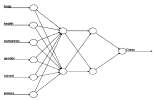
反向传播是使用最广泛的学习算法。它将神经网络的输出与期望值进行比较。然后它计算输出与期望值的差距有多大。这是对误差的衡量。接下来，它计算与前一层的每个神经元相关的误差。这个过程重复进行，直到到达输入层。由于误差是通过网络向后传播（从输出到输入属性）来调整权重和偏置，所以这种方法被称为反向传播。
## Step by Step Explanation
- 第1步:-网络的初始化。需要确定权重的初始值。神经网络一般采用随机权重进行初始化。
- 第2步:-前馈。信息通过节点激活函数和权重从输入层向前传递到隐藏层和输出层。激活函数是（通常）节点输入的加权和的sigmoidal（即上下有界，但可微分）函数。
- 第3步:-错误评估。评估误差是否足够小，以满足要求，或迭代次数是否达到预定的限度。如果满足其中一个条件，则训练结束。否则，迭代学习过程继续进行。
- 第4步:-传播。输出层的误差被用来重塑权重。该算法通过网络向后传播误差，并计算误差变化与权值变化的梯度。
- 第5步:-调整。利用变化的梯度对权重进行调整，以减少误差。根据激活函数的导数、网络输出与实际目标结果的差值和神经元输出，对每个神经元的权重和偏置进行系数调整。通过这个过程，网络就会 "学习"。

## Gradient Descent Clarified
梯度下降是在神经网络中进行优化的最流行算法之一。一般来说，我们希望找到最小化误差函数的权重和偏置。梯度下降迭代更新参数，以最小化整个网络的误差。它沿着损失函数的梯度方向反复更新权重参数，直到达到最小值。换句话说，我们沿着损失函数的斜率方向往下走，直到到达一个谷底。
## Stochastic Gradient Descent
随机梯度下降（SGD）是真实梯度的近似。在每次迭代时，它随机选择一个例子来更新参数，并相对于该例子的梯度方向移动。因此，它遵循一个有噪声的梯度路径来达到最小。由于缺乏冗余，它通常比传统的梯度下降法更快地收敛到一个解决方案。

随机梯度下降有一个相当不错的理论特性，就是如果损失函数是凸convex的，它就能保证找到全局最小值。只要在训练过程中缓慢降低学习率，SGD具有和传统梯度下降一样的收敛行为。
## How to Easily Specify a Model

In [17]:
from pyneurgen.neuralnet import NeuralNet
# here I made some change in the neuralnet.py

In [18]:
import random
random.seed(2020)
fit1 = NeuralNet()
fit1.init_layers(4,[7,3],1)
fit1.randomize_network() #The randomize_network method randomizes the weights and bias of each connection.

在fit1中实例化主类NeuralNet后，指定网络层。该模型包含4个输入属性，2个隐藏层，1个输出层。第一个隐藏层包含7个节点，第二个隐藏层有3个节点。
## Setting the Learning Rate
我们接下来的任务是指定学习率。它决定了梯度下降算法达到最小值所需步数的大小。

In [23]:
fit1.set_learnrate(0.05)
fit1.set_all_inputs(x)
fit1.set_all_targets(y)
length = len(x)
learn_end_point = int(length * 0.95)
fit1.set_learn_range(0, learn_end_point)
fit1.set_test_range(learn_end_point+1, length-1)

在上面的代码中，一旦指定了学习率，就会将属性和响应传递给fit1。我们使用95%的观测值来训练模型，剩余的观测值用于测试集。
## The Efficient Way to Run Your Model

In [24]:
fit1.layers[1].set_activation_type('tanh')
fit1.layers[2].set_activation_type('tanh')

In [25]:
fit1.learn(epochs=200,show_epoch_results=True,random_testing=False)
# 参数random_testing被设置为False以保持例子的顺序。模型运行了200个epoch

epoch: 0 MSE: 0.008007865210771912
epoch: 1 MSE: 0.0024197674965604904
epoch: 2 MSE: 0.0018758836060351867
epoch: 3 MSE: 0.0016544077997741491
epoch: 4 MSE: 0.0015225021423468826
epoch: 5 MSE: 0.0014234421919533595
epoch: 6 MSE: 0.0013403282385358545
epoch: 7 MSE: 0.0012672020574480466
epoch: 8 MSE: 0.0012015611628917045
epoch: 9 MSE: 0.001142124609458405
epoch: 10 MSE: 0.0010880934828814979
epoch: 11 MSE: 0.0010388847837603332
epoch: 12 MSE: 0.0009940277949190216
epoch: 13 MSE: 0.0009531200007021088
epoch: 14 MSE: 0.000915806239582552
epoch: 15 MSE: 0.0008817675933060273
epoch: 16 MSE: 0.000850714741635643
epoch: 17 MSE: 0.0008223835974500029
epoch: 18 MSE: 0.0007965322376060413
epoch: 19 MSE: 0.0007729386337018849
epoch: 20 MSE: 0.0007513989004795145
epoch: 21 MSE: 0.0007317258841436796
epoch: 22 MSE: 0.0007137479720872963
epoch: 23 MSE: 0.0006973080439385382
epoch: 24 MSE: 0.0006822625110027616
epoch: 25 MSE: 0.0006684804109512548
epoch: 26 MSE: 0.0006558425388688429
epoch: 27 MSE: 

## Assess Performance
性能是用均方误差（MSE）来衡量的。它的计算方法是将观察到的目标（y）和预测值（ŷ）之间的平方差相加，然后除以测试例子的数量（n）。
$MSE =\frac{1}{n}\sum_{i=1}^{n}(ŷ_i − y_i )^2$

In [26]:
mse = fit1.test()
np.round(mse, 6)

0.000203

In [28]:
test_reals = data['COE$'][learn_end_point + 1:length].tolist()
print("test_reals are (时间长度为%d):" % len(test_reals))
print(test_reals)

test_reals are (时间长度为13):
[10803.0, 11101.0, 12699.0, 13605.0, 15200.0, 14900.0, 13000.0, 12605.0, 14156.0, 14501.0, 14669.0, 13499.0, 13301.0]


In [30]:
# 模型反归一化变换得到真实际值
retrieved_reals = [np.exp(
    scaler_y.inverse_transform(np.array(item).reshape(-1, 1)
                              ))[0][0] for item in fit1.test_targets_activations]
print("retrieved_reals are(时间长度为%d):" % len(retrieved_reals))
print(retrieved_reals)

retrieved_reals are(时间长度为12):
[10802.999999999998, 11100.99999999999, 12699.000000000002, 13604.999999999989, 15200.000000000007, 14899.999999999967, 12999.99999999999, 12605.0, 14156.000000000004, 14501.000000000004, 14668.999999999995, 13499.000000000004]


In [32]:
# 模型对价格的预测值
forecast = [np.exp(scaler_y.inverse_transform(
            np.array(item).reshape(-1, 1)))[1][0] for item in fit1.test_targets_activations]
print("forecasts are(时间长度为%d):" % len(forecast))
print(forecast)

forecasts are(时间长度为12):
[11376.365020671166, 11652.409129625485, 11793.410931595541, 13887.909167774651, 14584.214524996894, 15418.727150164557, 12432.60769149443, 11992.936689014941, 11513.909962482037, 12784.091032735589, 13072.69286239841, 11923.581269227308]


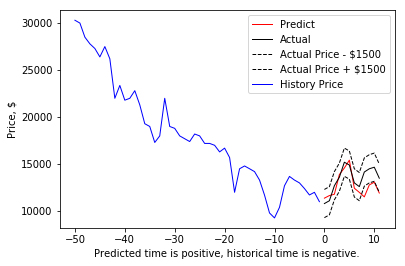

In [34]:
import matplotlib.pyplot as plt
real = np.array(data['COE$']).reshape(-1)
history_time_length = 50
ahead = 12
plt.plot(range(0, ahead), forecast, '-r', label=u"Predict", linewidth=1)
plt.plot(range(0, ahead), test_reals[0:ahead], color='black', label=u"Actual", linewidth=1)
plt.plot(range(0, ahead), np.array(test_reals[0:ahead]) - 1500, '--k',
             label=u"Actual Price - $1500", linewidth=1)
plt.plot(range(0, ahead), np.array(test_reals[0:ahead]) + 1500, '--k',
             label=u"Actual Price + $1500", linewidth=1)
plt.plot(range(-history_time_length, 0),
             real[len(real) - ahead - history_time_length - 1: len(real) - ahead - 1],
             '-b', label=u"History Price", linewidth=1)
plt.xlabel(u"Predicted time is positive, historical time is negative.")
plt.ylabel(u"Price, $")
plt.legend()

Text(0.5, 1.0, 'Mean Squared Error by Epoch')

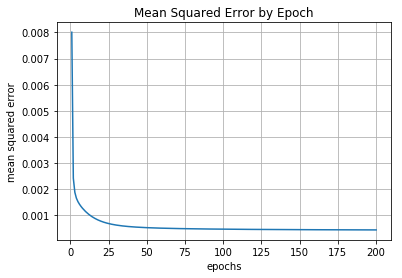

In [35]:
plt.plot(range(1, len(fit1.accum_mse) + 1, 1), fit1.accum_mse)
plt.xlabel('epochs')
plt.ylabel('mean squared error')
plt.grid(True)
plt.title("Mean Squared Error by Epoch")